# NTL9: hyperparameter-optimized mindist model

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
from glob import glob

## Data source

In [2]:
path  = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-0-protein/NTL9-0-protein/'
path2 = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-1-protein/NTL9-1-protein/'
trajs = 'NTL9-0-protein-*.dcd'
trajs2 = 'NTL9-1-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))] 
traj_files2 = [f for f in sorted(glob(path2 + trajs2))]

pdb_file = path + 'NTL9.pdb'

## Create a feature reader


In [3]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files, traj_files2], features=features, chunk_size=100000)

14-11-17 09:59:12 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretization

Following an extensive hyperparameter screening, I found that a TICA lagtime of 200 steps and projecting onto the first 30 eigenvectors yields the best implied timescale convergence.

To accoutn for the high dimensionality, I recommend to use at least 500 discrete states.

In [4]:
tica = pyemma.coordinates.tica(data=source, lag=200, dim=30)
cluster = pyemma.coordinates.cluster_kmeans(tica, k=500, max_iter=50)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

14-11-17 16:12:53 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 6 steps.


## Primary check: implied timescale convergence

The slowest timescale converges quickly to a roughly constant plateau. The second timescale follows after a considerable spectral gap and also seems rather flat in the linear plot.

A Jupyter Widget

A Jupyter Widget

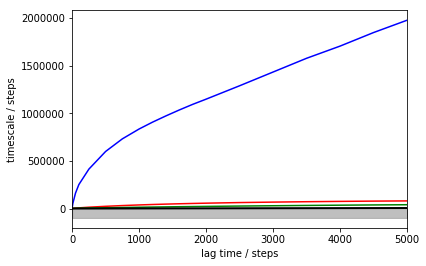

In [5]:
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(
        cluster.dtrajs,
        lags=[
            1, 10, 50, 100, 250, 500, 750, 1000,
            1200, 1400, 1600, 1800, 2000, 2500,
            3000, 3500, 4000, 4500, 5000],
        nits=3),
    ylog=False)

## Seondary check: CK test

We estimate an MSM at lagtime $\tau$=1500 steps and run a series of CK tests for two, three and four metastable sets.

A Jupyter Widget

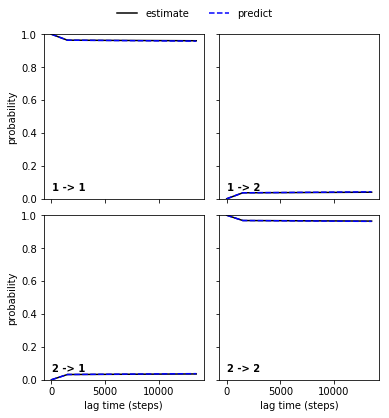

In [6]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1500, dt_traj='0.0002 us')
pyemma.plots.plot_cktest(msm.cktest(2));

A Jupyter Widget

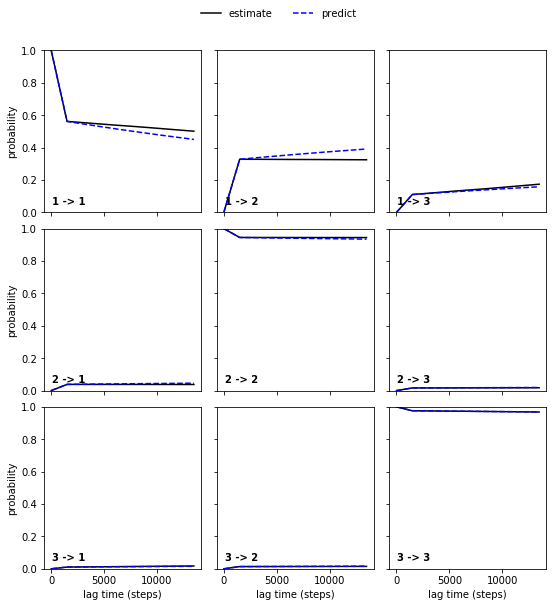

In [7]:
pyemma.plots.plot_cktest(msm.cktest(3));

A Jupyter Widget

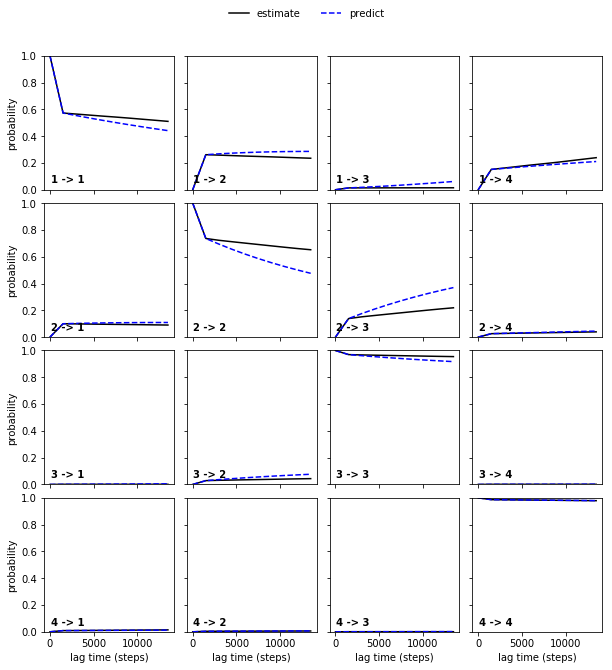

In [8]:
pyemma.plots.plot_cktest(msm.cktest(4));

Apparently, the two metastable state choice yields the best result.

## Timescales

Let's coarse grain the estimated MSM to two states and compute timescales and mean MFPTs for this HMM; the corresponding quantities of the MSM are shown, too.

In [9]:
hmm2 = msm.coarse_grain(2)
print('HMM: %7.2f us' % hmm2.timescales(k=1))
print('MSM: %7.2f us' % msm.timescales(k=1))

HMM:  121.49 us
MSM:  200.91 us


In [10]:
print('HMM: %7.2f us' % hmm2.mfpt(0, 1))
print('MSM: %7.2f us' % msm.mfpt(hmm2.metastable_sets[0], hmm2.metastable_sets[1]))

HMM:  236.88 us
MSM:  304.71 us


In [11]:
print('HMM: %7.2f us' % hmm2.mfpt(1, 0))
print('MSM: %7.2f us' % msm.mfpt(hmm2.metastable_sets[1], hmm2.metastable_sets[0]))

HMM:  250.05 us
MSM:  235.27 us


## Summary

The HMM (and MSM) MFPTs are in very good agreement with the range of (un-)folding timescales in the literature. Sampling frames from both states and visualizing their molecular structures would show which metsatable states were found by the MSM/HMM modelling.